In [24]:
import numpy as np
import matplotlib.pyplot as plt

# VARIABLES
n_air = 1                # Air index of refraction
n_glass = 1.5            # Glass index of refraction
height = 2.3             # Height of lens (cm)
num_lenses = 5           # How many lenses to stack
dz0 = 0.6                # Thickness of first slice (cm)
dz = 0.5                 # Thickness of slices (cm)
r = 4                    # Radius of the base of the lens
light_dist = 80          # Distance between lens and lightsource (cm)
num_incoming_rays = 10   # Number of incoming lightrays to simulate

# Generate lens slices
slice_radii = np.array([(r) / (1.8**i) for i in range(num_lenses)])
curvature_radii = np.array([(9 * r / (2**i), 9 * r / (2**(i+1))) for i in range(num_lenses)])

# Define Matrixes
def lens_matrix(R1, R2):
    f = 1 / ((n_glass - 1) * (1 / R1 - 1 / R2))
    return np.array([[1, 0], [-1 / f, 1]])

def propagation_matrix(d):
    return np.array([[1, d], [0, 1]])

# Define Tracing Functions
def air_tracing(y1, theta1_deg, dist):
    theta1 = np.deg2rad(theta1_deg)
    M_prop_air = propagation_matrix(dist)
    y2, theta2 = M_prop_air @ [y1, theta1]
    return y2, np.rad2deg(theta2), dist

def lens_tracing(y1, theta1_deg, lens_number):
    lens_rad = slice_radii[lens_number]
    R1, R2 = curvature_radii[lens_number]
    theta1 = np.deg2rad(theta1_deg)
    
    if np.abs(y1) >= lens_rad:  # lightray does not touch any lens
        if lens_number == 0:
            print('Lightray does not touch any lens')
        else:
            theta2 = np.arcsin(np.sin(theta1) * (n_glass / n_air))  # Snell's Law from glass into air
            y2 = y1
            return y2, np.rad2deg(theta2), 0
    else: 
        y2, theta2 = lens_matrix(R1, R2) @ [y1, theta1]
        
        if (-np.pi/4) < theta2 < (np.pi/4):
            y1, theta1 = y2, theta2
            
            if lens_number == 0:
                y2, theta2 = propagation_matrix(dz0) @ [y1, theta1]
                return y2, np.rad2deg(theta2), dz0
            else:
                d = np.sin(((lens_rad - np.abs(y1)) * np.pi) / (2*lens_rad)) * dz
                y2, theta2 = propagation_matrix(d) @ [y1, theta1]
                return y2, np.rad2deg(theta2), d
            
        else:
            print(f"Paraxial NOT Valid Angle: {np.rad2deg(theta2)}")

def total_ray_tracing(y1, theta1_deg):
    y, theta_deg, air_dist = air_tracing(y1, theta1_deg, light_dist)
    lens_dist = 0
    for i in range(num_lenses):
        y_new, theta_deg_new, dist = lens_tracing(y, theta_deg, i)
        if dist == 0:
            break
        else:
            lens_dist += dist
            y, theta_deg = y_new, theta_deg_new
    dist_trav = air_dist + lens_dist
    return y, theta_deg, dist_trav

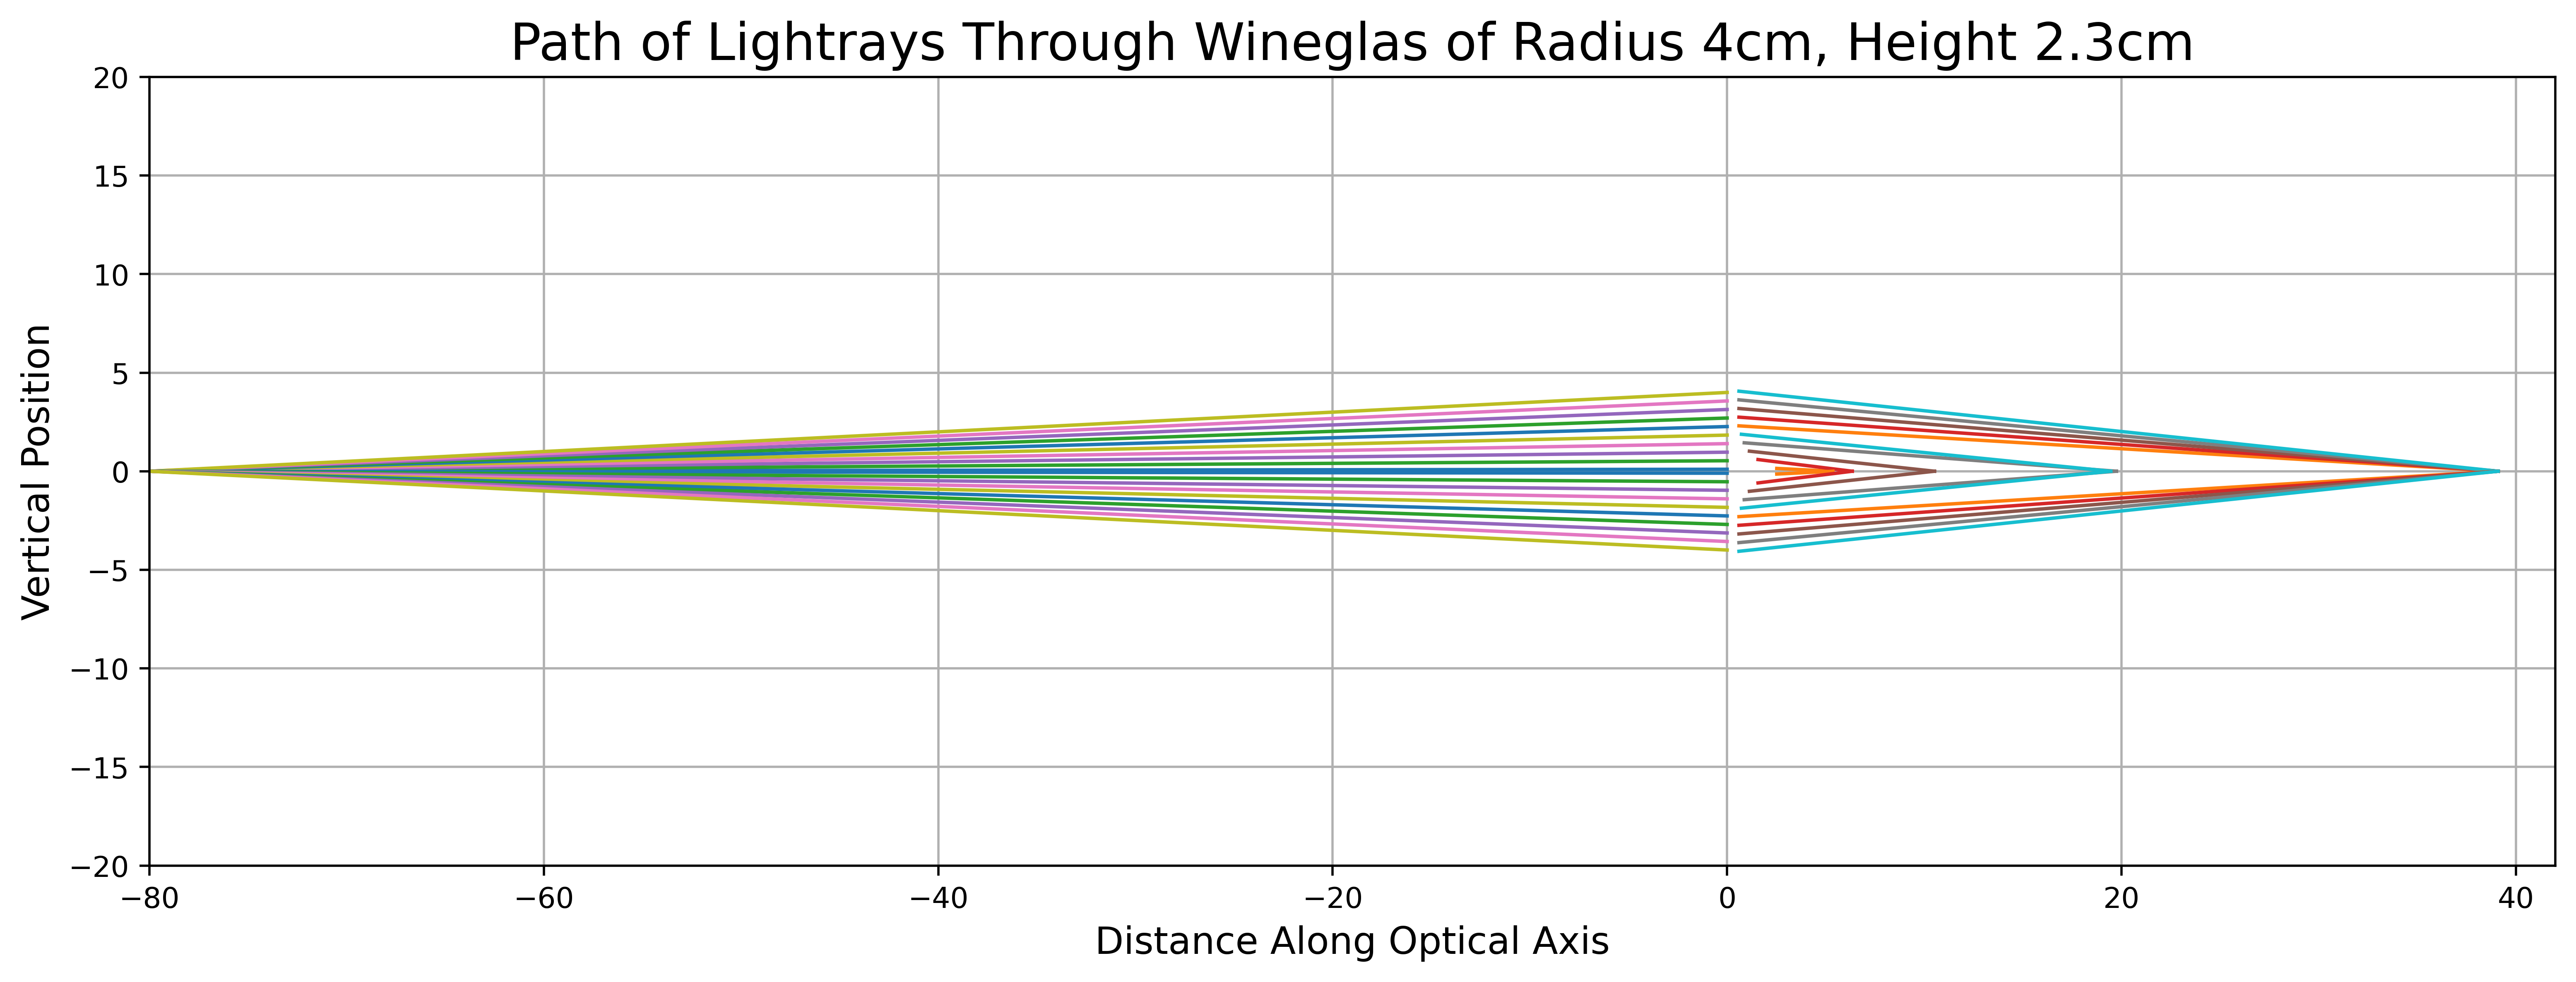

In [33]:
# Generate spaced incident angles
radii4angles = np.linspace(0.1, r, num_incoming_rays)
angles_rad = np.arctan(np.concatenate([radii4angles, -radii4angles]) / light_dist)
incoming_degrees = np.rad2deg(angles_rad)
incoming_degrees_list = incoming_degrees.tolist()

# Plot Rays
fig, ax = plt.subplots(figsize=(15, 15), dpi=500)
for angle in incoming_degrees_list:
    # Call Ray Tracing Function 
    y2, theta2, dist_trav = total_ray_tracing(0, angle)
    
    # Incoming Rays
    y1, _, _ = air_tracing(0, angle, light_dist)
    z_inc_arr = np.array([-light_dist, 0])
    y_inc_arr = np.array([0, y1])
    ax.plot(z_inc_arr, y_inc_arr, linewidth=1.2)
    
    # Outgoing Rays
    y2, theta2, dist_travelled = total_ray_tracing(0, angle)
    dist_to_y0 = y2/np.deg2rad(theta2)
    z_start = dist_trav - light_dist
    z_end = z_start + dist_to_y0
    z_arr = np.array([z_start, z_end])
    y_arr = np.array([y2, 0])
    ax.plot(z_arr, y_arr, linewidth=1.2)

# Set aspect ratio
ax.set_aspect('equal')
ax.set_ylim(-20,20)
ax.set_xlim(-80, 42)

# Format Plot
ax.set_xlabel("Distance Along Optical Axis", fontsize=13)
ax.set_ylabel("Vertical Position", fontsize=13)
ax.set_title(f"Path of Lightrays Through Wineglas of Radius {r}cm, Height {height}cm", fontsize=18)
ax.grid(True)
plt.show()


In [ ]:
#plt.savefig("C:/Users/taisl/Desktop/raytrace-wineglass-small.png", dpi=300, bbox_inches="tight")


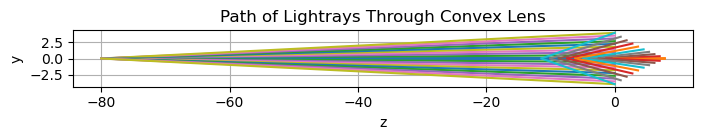

In [19]:
convex_thickness = 2  #cm
convex_rad = r  #cm

def convex_lens_tracing(y1, theta1_deg):
    R1, R2 = 10*convex_rad, -10*convex_rad
    theta1 = np.deg2rad(theta1_deg)
    
    if np.abs(y1) >= convex_rad:  # lightray does not touch any lens
        print('Lightray does not touch any lens')

    else: 
        y2, theta2 = lens_matrix(R1, R2) @ [y1, theta1]
        
        if (-np.pi/4) < theta2 < (np.pi/4):
            y1, theta1 = y2, theta2
            d = ((convex_rad - np.abs(y1)) * convex_thickness) / convex_rad
            y2, theta2 = propagation_matrix(d) @ [y1, theta1]
            return y2, np.rad2deg(theta2), d
        else:
            print(f"Paraxial NOT Valid Angle: {np.rad2deg(theta2)}")
            
def total_ray_tracing_convex(y1, theta1_deg):

    y, theta_deg, air_dist = air_tracing(y1, theta1_deg, light_dist)
    
    lens_dist = 0
    for i in range(num_lenses):
        y_new, theta_deg_new, dist = convex_lens_tracing(y, theta_deg)
        if dist == 0:
            break
        else:
            lens_dist += dist
            y, theta_deg = y_new, theta_deg_new
    dist_trav = air_dist + lens_dist
    return y, theta_deg, dist_trav

# Plot Rays
fig, ax = plt.subplots(figsize=(8, 8))
for angle in incoming_degrees_list:
    # Call Ray Tracing Function 
    y2, theta2, dist_trav = total_ray_tracing_convex(0, angle)
    
    # Incoming Rays
    y1, _, _ = air_tracing(0, angle, light_dist)
    z_inc_arr = np.array([-light_dist, 0])
    y_inc_arr = np.array([0, y1])
    ax.plot(z_inc_arr, y_inc_arr)
    
    # Outgoing Rays
    y2, theta2, dist_travelled = total_ray_tracing_convex(0, angle)
    dist_to_y0 = y2/np.deg2rad(theta2)
    z_start = dist_trav - light_dist
    z_end = z_start + dist_to_y0
    z_arr = np.array([z_start, z_end])
    y_arr = np.array([y2, 0])
    ax.plot(z_arr, y_arr)

ax.set_xlabel("z")
ax.set_ylabel("y")
ax.set_title("Path of Lightrays Through Convex Lens")
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
plt.show()